In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
ages_ethnicity_np = np.load("../data/eICU_age_ethnicity.npy", allow_pickle=True)
print('length: ', len(ages_ethnicity_np))
print(ages_ethnicity_np[0:5])

ages_np = np.asarray(ages_ethnicity_np[:,0].flatten().tolist()).flatten()
print('ages length: ', len(ages_np))
print(ages_np[0:5])

ethnicity_np = np.asarray(ages_ethnicity_np[:,1].flatten().tolist()).flatten()
print('ethnicity length: ', len(ethnicity_np))
print(ethnicity_np[0:5])

df_ages = pd.DataFrame(zip(ages_np, ethnicity_np), columns=['age','ethnicity'])
#print(df_ages.shape)
df_ages.groupby('ethnicity').describe()

mean_age = df_ages['age'].mean()
std_age = df_ages['age'].std()
min_age = df_ages['age'].min()
max_age = df_ages['age'].max()

print("mean age: ", mean_age)
print("std age: ", std_age)
print("min age: ", min_age)
print("max age: ", max_age)

scaled_ages = [(x - min_age)/(max_age - min_age) for x in df_ages['age']]

#scaled_ages = np.array(scaled_ages)

print(scaled_ages[0:5])

# create data set without 90 or greater since that was a category flattened
#print("==" * 30)
#print("FILTERED:")
#filter_arr = ages_np_ary < 88
#ages_np_filtered = ages_np_ary[filter_arr]
#print('length: ', len(ages_np_filtered))
#print(ages_np_filtered[0:5])

#mean_age_filtered = ages_np_filtered.mean()
#std_age_filtered = ages_np_filtered.std()
#min_age_filtered = ages_np_filtered.min()
#max_age_filtered = ages_np_filtered.max()

#print("mean age: ", mean_age_filtered)
#print("std age: ", std_age_filtered)

#scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in ages_np_filtered]
#scaled_ages_filtered = np.array(scaled_ages_filtered)

#print(scaled_ages_filtered[0:5])



length:  2253
[[(87,) ('Caucasian',)]
 [(87,) ('Caucasian',)]
 [(76,) ('Caucasian',)]
 [(34,) ('Caucasian',)]
 [(61,) ('Caucasian',)]]
ages length:  2253
[87 87 76 34 61]
ethnicity length:  2253
['Caucasian' 'Caucasian' 'Caucasian' 'Caucasian' 'Caucasian']
mean age:  63.51930758988016
std age:  17.578022090713127
min age:  15
max age:  90
[0.96, 0.96, 0.8133333333333334, 0.25333333333333335, 0.6133333333333333]


<function matplotlib.pyplot.show(close=None, block=None)>

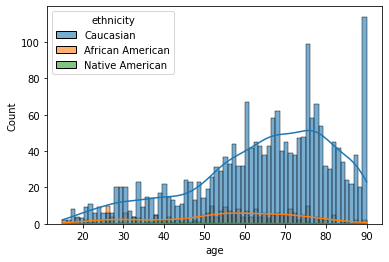

In [4]:
sns.histplot(data=df_ages, x='age', hue='ethnicity', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

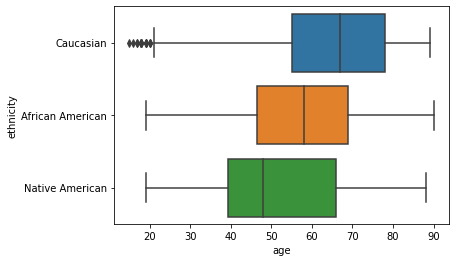

In [5]:
sns.boxplot(data=df_ages, x='age',  y='ethnicity')
plt.show

In [5]:
# one hot encode the ethnicity
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df_ages[['ethnicity']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df_ages.join(encoder_df)

final_df.columns = ['age', 'ethnicity', 'African_American', 'Caucasian', 'Native_American']
final_df["ethnicity"] = final_df["ethnicity"].astype('category')
final_df["ethnicity_code"] = final_df["ethnicity"].cat.codes

final_df.describe()

,age,African_American,Caucasian,Native_American,ethnicity_code
count,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000
mean,63.519308,0.102530,0.892144,0.005326,0.902796
std,17.578022,0.303411,0.310268,0.072803,0.313770
min,15.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.000000,1.000000,0.000000,1.000000
50%,67.000000,0.000000,1.000000,0.000000,1.000000
75%,77.000000,0.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,2.000000


In [12]:
all_data = np.asarray(scaled_ages)
all_labels = np.asarray([[a,c,n] for a,c,n in zip(final_df['African_American'],final_df['Caucasian'],final_df['Native_American'])])

print("scaled first 5 ages: ",all_data[0:5])
print("first 5 labels: ", all_labels[0:5])

print(f"Shape of training ages: {all_data.shape}")
print(f"Shape of training labels: {all_labels.shape}")

train_data = [all_data, all_labels]


scaled first 5 ages:  [0.96       0.96       0.81333333 0.25333333 0.61333333]
first 5 labels:  [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Shape of training ages: (2253,)
Shape of training labels: (2253, 3)


In [ ]:
class GAN():
    def __init__(self, train_data,
                 noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False):

        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes
        self.train_data = train_data # train data
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)

        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

        if (self.verbose):
            print("Built Generator and Discriminator")

        # set the compiler loss == mse        
        self.discriminator.compile(loss='mse',
            optimizer=self.d_optimizer,
            metrics=['accuracy'])
        
        # The generator takes noise as input and generated the events 
        z = Input(shape=(self.g_dim,))

        # e == age
        e = self.generator(z)
        print(e.shape)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(e)
        
        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        # takes noise, return output
        self.combined = Model(z, [valid])
        self.combined.compile(loss='mse', optimizer=self.g_optimizer)
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
        output = Dense(self.d_dim, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)

        generator = Model(inputs=inputs, outputs=output)
        generator.summary()

        return generator


    def build_discriminator(self):
        "build the discriminator model"
        inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.data_shape,))(inputs)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        model = Model(inputs, h)
        model.summary()
        return model


    def train(self, epochs, sample_interval=50):
        # discriminator labels
        # fake batch labels - 0's
        fake = np.zeros((self.batch_size), 1)
        # real batch labels - 1's
        valid = np.ones((self.batch_size), 1)

        for epoch in range(self.start_epoch, epochs):
            
            train_data_ages, train_data_labels = self.train_data            

            # randomly selected indices for the samples for the batch
            indices = np.random.randint(0, train_data_ages.shape[0], self.batch_size)
            # get the randomly selected items from train_data
            batch_inputs_ages = self.train_data_ages[indices]
            batch_inputs_labels = self.train_data_labels[indices]
   
            # generate noisy input
            noise = tf.random.normal((self.batch_size, self.noise_dim), 0, 1)

            gen_data = self.generator.predict(noise)
            
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_inputs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.combined.train_on_batch(noise, [valid])

            if epoch % sample_interval == 0 or epoch == (epochs - 1):
                #self.generator.save("/work/data_science/kishan/Theory/2022.03.20_withNorm_generator_4Params_v2.h5")
                #self.discriminator.save("/work/data_science/kishan/Theory/2022.03.20_withNorm_discriminator_4Params_v2.h5")
                
                num = 2520
                gen_data = self.generate(num)
                
                # plot generated and real
                sns.histplot(gen_data, bins=90, label='GAN')
                sns.histplot(self.train_data, bins=90, color='orange', label='Truth')
                plt.legend()
                plt.show()

    def generate(self, n=None):
        if n == None:
            n = self.train_data.shape[0]

        if (self.verbose):
            print("Generating: ", n, " events...")

        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        generated_data = self.generator(input_noise)

        return generated_data.numpy()

In [ ]:
gan = GAN(scaled_ages, noise_dim=250, data_shape=1, d_learning_rate=8e-4, g_learning_rate=8e-5, batch_size=751, verbose=True)

In [ ]:
gan.train(15000, sample_interval=5000)

In [ ]:
syn_data = gan.generate(2520)
inv_scaled_gen_ages = [(val * (max_age-min_age)) + min_age for val in syn_data]

In [ ]:
print(np.array(inv_scaled_gen_ages).mean())
print(np.array(inv_scaled_gen_ages).std())

In [ ]:
print(ages_np_ary.mean())
print(ages_np_ary.std())

In [ ]:
sns.histplot(syn_data, bins=70, label='GAN')
sns.histplot(scaled_ages, bins=70, color='orange', label='Truth', alpha=0.3)
plt.legend()
plt.show

In [ ]:
gan_filtered = GAN(scaled_ages_filtered, noise_dim=250, data_shape=1, d_learning_rate=8e-4, g_learning_rate=8e-5, batch_size=197)

In [ ]:
gan_filtered.train(15000, sample_interval=5000)

In [ ]:
syn_data_fil = gan_filtered.generate(2520)
sns.histplot(syn_data_fil, bins=70, label='GAN')
sns.histplot(scaled_ages_filtered, bins=70, color='orange', label='Truth', alpha=0.3)
plt.legend()
plt.show